See  https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=KcAZ2RHCg_Ze

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [ ]:
project_id = 'centered-oasis-297411'


In [ ]:
%env GCLOUD_PROJECT=centered-oasis-297411

env: GCLOUD_PROJECT=centered-oasis-297411


In [ ]:
# Source: https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py

import time
import pandas as pd

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.
    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1
        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.
        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
data=[list(x.values()) for x in results], columns=list(results[0].keys()))

In [ ]:
bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos")
bq_assistant.list_tables()
bq_assistant.table_schema("licenses")
bq_assistant.head("licenses", num_rows=10)

,repo_name,license
0,azuredream/chat_server-client,artistic-2.0
1,Egyptian19/JemCraft,artistic-2.0
2,ZioRiP/cookie,artistic-2.0
3,ajs/perl6-log,artistic-2.0
4,JohanPotgieter/Internet,artistic-2.0
5,myafrica/java_snippets,artistic-2.0
6,gitpan/Net-Moip,artistic-2.0
7,DubiousYak/house,artistic-2.0
8,JJ/Infraestructura-como-servicio,artistic-2.0
9,tnalpgge/ant-docbook-dummy,artistic-2.0


## **TASK 1**
Advanced guide to analyzing variants using BigQuery tutorial

# Counting the variants called by each sample

Each variant in the table has zero or more values for call.name. A particular call.name value can appear in multiple rows.

To count the number of rows in which each call set appears, run the following query:


In [ ]:
QUERY1 = """
SELECT
  call.name AS call_name,
  COUNT(call.name) AS call_count_for_call_set
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
GROUP BY
  call_name
ORDER BY
  call_name
"""

In [ ]:
bq_assistant.estimate_query_size(QUERY1)  

1.5263835601508617

In [ ]:
df1 = bq_assistant.query_to_pandas_safe(QUERY1,max_gb_scanned = 2)

In [ ]:
df1

,call_name,call_count_for_call_set
0,NA12877,31592135
1,NA12878,28012646
2,NA12889,31028550
3,NA12890,30636087
4,NA12891,33487348
5,NA12892,27347886


# Filtering true variants by genotype
The variants in the table include no-calls, which are represented by a genotype value of -1. These variants are not considered true variants for individuals, so filter them out. True variants can only include calls with genotypes greater than zero. If a call includes only genotypes that are no-calls (-1) or reference (0), then they are not true variants.

To filter the variants by genotype:

In [ ]:
QUERY2="""
SELECT
  call.name AS call_name,
  COUNT(call.name) AS call_count_for_call_set
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v, v.call
WHERE
  EXISTS (SELECT 1 FROM UNNEST(call.genotype) AS gt WHERE gt > 0)
  AND NOT EXISTS (SELECT 1 FROM UNNEST(call.genotype) AS gt WHERE gt < 0)
GROUP BY
  call_name
ORDER BY
  call_name
  """

In [ ]:
bq_assistant.estimate_query_size(QUERY2) 

4.239954333752394

In [ ]:
df2 = bq_assistant.query_to_pandas_safe(QUERY2,max_gb_scanned = 5)
df2

,call_name,call_count_for_call_set
0,NA12877,4486610
1,NA12878,4502017
2,NA12889,4422706
3,NA12890,4528725
4,NA12891,4424094
5,NA12892,4495753


# per-variant-call FILTER values

The VCF specification describes the FILTER column which can be used to label variant calls of differing qualities.

The following query shows how to view the per-variant-call FILTER values for the dataset:

In [ ]:
QUERY3 = """
SELECT
  call_filter,
  COUNT(call_filter) AS number_of_calls
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v,
  v.call,
  UNNEST(call.FILTER) AS call_filter
GROUP BY
  call_filter
ORDER BY
  number_of_calls
  """

In [ ]:
bq_assistant.estimate_query_size(QUERY3)    

0.24804932065308094

In [ ]:
df3 = bq_assistant.query_to_pandas_safe(QUERY3)

In [ ]:
df3.head()

,call_filter,number_of_calls
0,RefCall,11681534
1,PASS,26867854


The PASS value signifies that a variant call is of a high quality.

# Counting variants per chromosome


*  Counts all rows in which there is at least one variant call with at least one genotype greater than 0
*   Groups the variant rows by chromosome and counts each group


Running the query returns the name of the chromosome (reference_name) and the number of variant rows for each chromosome:

In [ ]:
QUERY4= """       
  SELECT
    reference_name,
    COUNT(reference_name) AS number_of_variant_rows
  FROM
    `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
  WHERE
    EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
  GROUP BY
    reference_name
  ORDER BY
    CASE
      WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
        THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
        ELSE REGEXP_REPLACE(reference_name, '^chr', '')
    END
       """

In [ ]:
bq_assistant.estimate_query_size(QUERY4)    

3.341447635553777

In [ ]:
df4 = bq_assistant.query_to_pandas_safe(QUERY4,max_gb_scanned = 5)

In [ ]:

df4.head()

,reference_name,number_of_variant_rows
0,chr1,615000
1,chr2,646401
2,chr3,542315
3,chr4,578600
4,chr5,496202


The query uses the REGEXP_REPLACE function to replace the "chr" prefix string with an empty string. It then changes the GROUP BY and ORDER BY functions to use the computed chromosome alias. However, the output still sorts by string:

In [ ]:
QUERY5="""
SELECT
  REGEXP_REPLACE(reference_name, '^chr', '') AS chromosome,
  COUNT(reference_name) AS number_of_variant_rows
FROM
  `bigquery-public-data.human_genome_variants.platinum_genomes_deepvariant_variants_20180823` v
WHERE
  EXISTS (SELECT 1
            FROM UNNEST(v.call) AS call, UNNEST(call.genotype) AS gt
          WHERE gt > 0)
GROUP BY
  chromosome
ORDER BY
  chromosome
  """

In [ ]:
bq_assistant.estimate_query_size(QUERY5) 

3.341447635553777

In [ ]:
df5 = bq_assistant.query_to_pandas_safe(QUERY5,max_gb_scanned = 5)
df5

,chromosome,number_of_variant_rows
0,1,615000
1,10,396773
2,11,391260
3,12,382841
4,13,298044
5,14,258756
6,15,234569
7,16,247671
8,17,224403
9,18,227200


# TASK **2**
Exploring the Phenotypic Data

### **How many sample are we working with in this variant dataset?**

In  this  query  we  count  the  total  number  of  samples  present,and  along  with  the  count  of  samples  in  Phase  1  Integrated  Variant  Set,  through writing a condition SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table.

In [ ]:
# Count the number of samples in the phenotypic data
QUERY1="""
SELECT
  COUNT(sample) AS all_samples,
  SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table
FROM
  `genomics-public-data.1000_genomes.sample_info`
  """

In [ ]:
bq_assistant.estimate_query_size(QUERY1) 

2.3853033781051636e-05

In [ ]:
df = client.query(QUERY1).to_dataframe()

In [ ]:
df.head()

,all_samples,samples_in_variants_table
0,3500,1092


In [ ]:
import matplotlib.pyplot as plt

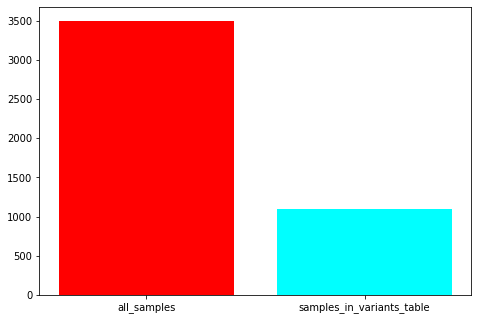

In [ ]:
#From DataFrame
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
samples = list(df.columns)
values = df.iloc[0,:].values
ax.bar(samples, values, color = ['red', 'cyan'])
plt.show()

The 1092 samples as part of Phase 1 Integrated Varianted is now divided among Males and Females, and we are finding the count of each and their ratio in the sample.

In [ ]:
QUERY1="""
SELECT
  gender,
  gender_count,
  (gender_count/SUM(total_count) OVER (PARTITION BY gender)) as gender_ratio
FROM (
  SELECT
    gender,
    COUNT(gender) AS gender_count
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY gender
    ),(select count(gender) as total_count from  `genomics-public-data.1000_genomes.sample_info` where In_Phase1_Integrated_Variant_Set = TRUE)
"""

In [ ]:
bq_assistant.estimate_query_size(QUERY1) 

2.3853033781051636e-05

In [ ]:
df1 = bq_assistant.query_to_pandas_safe(QUERY1,max_gb_scanned = 3)
df1

,gender,gender_count,gender_ratio
0,female,567,0.519231
1,male,525,0.480769


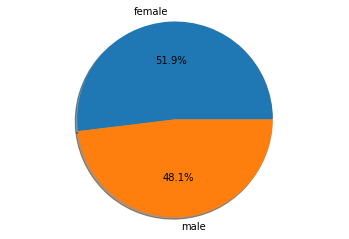

In [ ]:
import matplotlib.pyplot as plt


labels = df1["gender"]
sizes = df1["gender_count"]


fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

After finding the ratio between the gender, this query does the same for ethnicity of the whole sample of population (1092) along with the ancestry.

In [ ]:
QUERY2= """
SELECT
  population,
  population_description,
  population_count,
  (population_count/SUM(total_count) OVER (PARTITION BY population))  AS population_ratio,
  super_population,
  super_population_description,
from(
  SELECT
    population,
    population_description,
    super_population,
    super_population_description,
    COUNT(population) AS population_count,
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    population,
    population_description,
    super_population,
    super_population_description),(select count(population) as total_count from  `genomics-public-data.1000_genomes.sample_info` where In_Phase1_Integrated_Variant_Set = TRUE) order by population_ratio
    """

In [ ]:
bq_assistant.estimate_query_size(QUERY2) 

0.0001673717051744461

In [ ]:
df2 = bq_assistant.query_to_pandas_safe(QUERY2)
df2

,population,population_description,population_count,population_ratio,super_population,super_population_description
0,IBS,Iberian populations in Spain,14,0.012821,EUR,European
1,PUR,Puerto Rican in Puerto Rico,55,0.050366,AMR,American
2,CLM,"Colombian in Medellin, Colombia",60,0.054945,AMR,American
3,ASW,African Ancestry in Southwest US,61,0.055861,AFR,African
4,MXL,"Mexican Ancestry in Los Angeles, California",66,0.060440,AMR,American
5,CEU,Utah residents with Northern and Western Europ...,85,0.077839,EUR,European
6,YRI,"Yoruba in Ibadan, Nigeria",88,0.080586,AFR,African
7,GBR,British in England and Scotland,89,0.081502,EUR,European
8,JPT,"Japanese in Tokyo, Japan",89,0.081502,EAS,East Asian
9,FIN,Finnish in Finland,93,0.085165,EUR,European


In [ ]:
colours = {"EUR": "blue", "AMR": "red","AFR":"orange","EAS":"green"}

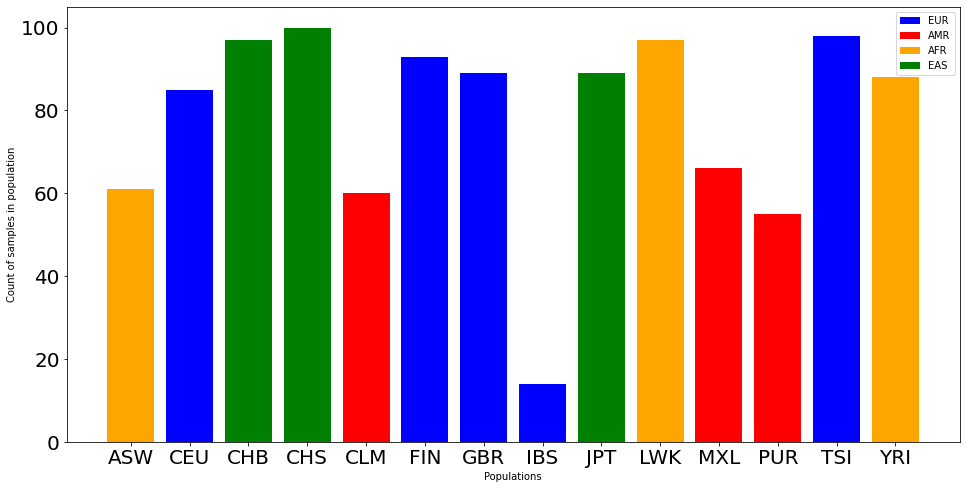

In [ ]:
from matplotlib.patches import Patch
#plt.xticks(df2["population_count"], df2["population"])
plt.figure(figsize=(16, 8))
plt.xlabel('Populations')
plt.ylabel('Count of samples in population')
test_df = df2.sort_values(by=['population'])


#colors = tuple(np.where(test_df["super_population"] =="EAS", 'green','red') )
plt.bar(test_df["population"],test_df["population_count"], color=test_df["super_population"].replace(colours))
plt.legend(
    [
        Patch(facecolor=colours['EUR']),
        Patch(facecolor=colours['AMR']),
        Patch(facecolor=colours['AFR']),
        Patch(facecolor=colours['EAS'])
    ], ["EUR", "AMR","AFR","EAS"]
) 
plt.show()

We are finding the ratio of the super population (Ethnicity/Origin) in the sub sample set. We see the samples ration from 0.16 to 0.34

In [ ]:
QUERY3= """
SELECT
  super_population,
  super_population_description,
  super_population_count,
   (super_population_count/SUM(total_count) OVER (PARTITION BY super_population)) AS super_population_ratio
from(
  SELECT
    super_population,
    super_population_description,
    COUNT(population) AS super_population_count,
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    super_population,
    super_population_description),(select count(super_population) as total_count from  `genomics-public-data.1000_genomes.sample_info` where In_Phase1_Integrated_Variant_Set = TRUE)  ORDER BY super_population_ratio
    """

In [ ]:
bq_assistant.estimate_query_size(QUERY3) 

6.825756281614304e-05

In [ ]:
df3 = bq_assistant.query_to_pandas_safe(QUERY3)
df3

,super_population,super_population_description,super_population_count,super_population_ratio
0,AMR,American,181,0.165751
1,AFR,African,246,0.225275
2,EAS,East Asian,286,0.261905
3,EUR,European,379,0.347070


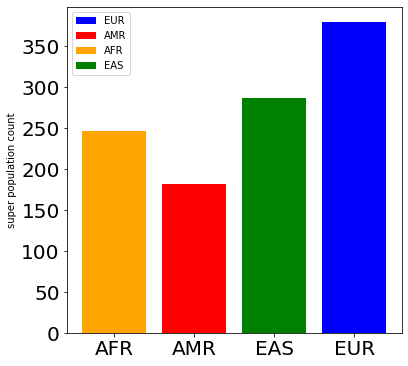

In [ ]:
from matplotlib.patches import Patch
#plt.xticks(df2["population_count"], df2["population"])
plt.figure(figsize=(6, 6))

plt.ylabel('super population count')
test_df = df3.sort_values(by=['super_population'])


#colors = tuple(np.where(test_df["super_population"] =="EAS", 'green','red') )
plt.bar(test_df["super_population"],test_df["super_population_count"], color=test_df["super_population"].replace(colours))
plt.legend(
    [
        Patch(facecolor=colours['EUR']),
        Patch(facecolor=colours['AMR']),
        Patch(facecolor=colours['AFR']),
        Patch(facecolor=colours['EAS'])
    ], ["EUR", "AMR","AFR","EAS"]
) 
plt.show()

We subdivided the ethnic population ratio into Males and Females and calculated the ratio of males per ethnic population and female per ethnic population among over all sub sample of population. In query 3, we found IBS ethnicity having the least population of all, and could see the sample of Finnish people living in Finland have a lot more number of Females compared to Males.

In [ ]:
QUERY4= """
SELECT
  population,
  gender,
  population_count,
  (population_count/SUM(total_count) OVER (PARTITION BY gender))
  AS population_ratio
from(
  SELECT
    gender,
    population,
    COUNT(population) AS population_count,
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    gender,
    population)
,(select count(population) as total_count from  `genomics-public-data.1000_genomes.sample_info` where In_Phase1_Integrated_Variant_Set = TRUE)  ORDER BY population, gender
    """

In [ ]:
bq_assistant.estimate_query_size(QUERY4) 

4.015117883682251e-05

In [ ]:
df4 = bq_assistant.query_to_pandas_safe(QUERY4)
df4

,population,gender,population_count,population_ratio
0,ASW,female,37,0.002420
1,ASW,male,24,0.001570
2,CEU,female,40,0.002616
3,CEU,male,45,0.002943
4,CHB,female,53,0.003467
5,CHB,male,44,0.002878
6,CHS,female,50,0.003271
7,CHS,male,50,0.003271
8,CLM,female,31,0.002028
9,CLM,male,29,0.001897


In [ ]:
female_df=df4.query('gender=="female"')
female_df

,population,gender,population_count,population_ratio
0,ASW,female,37,0.002420
2,CEU,female,40,0.002616
4,CHB,female,53,0.003467
6,CHS,female,50,0.003271
8,CLM,female,31,0.002028
10,FIN,female,58,0.003794
12,GBR,female,48,0.003140
14,IBS,female,7,0.000458
16,JPT,female,39,0.002551
18,LWK,female,49,0.003205


In [ ]:
male_df=df4.query('gender=="male"')
male_df

,population,gender,population_count,population_ratio
1,ASW,male,24,0.001570
3,CEU,male,45,0.002943
5,CHB,male,44,0.002878
7,CHS,male,50,0.003271
9,CLM,male,29,0.001897
11,FIN,male,35,0.002289
13,GBR,male,41,0.002682
15,IBS,male,7,0.000458
17,JPT,male,50,0.003271
19,LWK,male,48,0.003140


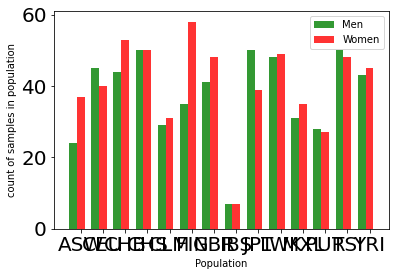

In [ ]:



fig, ax = plt.subplots()
index =np.arange(14)
bar_width = 0.35
opacity =0.8

rects1 = plt.bar(index, male_df["population_count"], bar_width,
alpha=opacity,
color='g',
label='Men')

rects2 = plt.bar(index + bar_width, female_df["population_count"], bar_width,
alpha=opacity,
color='r',
label='Women')

plt.xlabel('Population')
plt.ylabel('count of samples in population')

plt.xticks(index + bar_width, ('ASW','CEU','CHB','CHS','CLM','FIN','GBR','IBS','JPT','LWK','MXL','PUR','TSI','YRI'))
plt.legend()

#plt.tight_layout()
plt.show()

Since there could be a possibility of these people related to each other, or could be a part of family, we will distribute the family sizes as well. 

In [ ]:
QUERY5= """
SELECT
num_family_members AS family_size,
COUNT(num_family_members) AS num_families_of_size
FROM (
  SELECT
  family_id,
  COUNT(family_id) AS num_family_members,
  FROM
  `genomics-public-data.1000_genomes.sample_info`
  WHERE
  In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
  family_id)
GROUP BY
family_size
    """

In [ ]:
bq_assistant.estimate_query_size(QUERY5) 

2.4281442165374756e-05

In [ ]:
df5 = bq_assistant.query_to_pandas_safe(QUERY5)
df5

,family_size,num_families_of_size
0,1,636
1,2,204
2,3,12
3,4,3


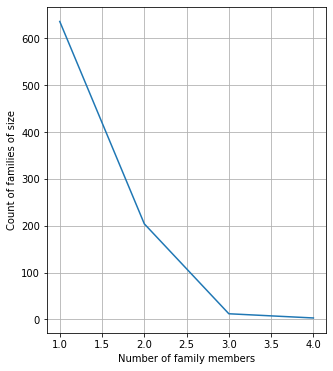

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 6))
plt.plot(df5["family_size"],df5["num_families_of_size"])
plt.xlabel('Number of family members')
plt.ylabel('Count of families of size')
plt.grid(True)
plt.show()